In [94]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [95]:
import numpy as np
import pandas as pd

In [96]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [97]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [98]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [99]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [239]:
# We can view all of the classes that automap found
Base.classes.keys()
# Save references to each table
# measurement = Base.classes.measurement
# station = Base.classes.station


['measurement', 'station']

In [162]:
# trying inspector to see tables
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [223]:
# engine.execute('SELECT * FROM station LIMIT 10').fetchall()
# engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

# Create our session (link) from Python to the DB
session = Session(bind=engine)
session.query(measurement.date).count()

for row in session.query(measurement.date, measurement.prcp).limit(5).all():
    print(row)
    
# measurement.__table__.columns.values()
# station.__table__.columns.values()

19550

# Exploratory Climate Analysis

C:\Users\jddar\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 0, 'Date')

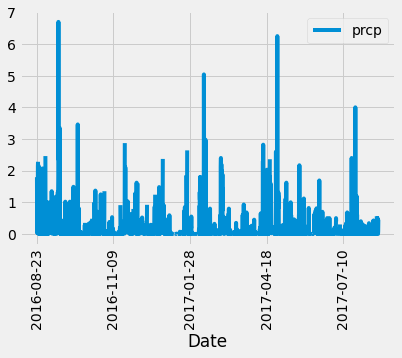

In [304]:
# Design a query to retrieve the last 12 months of precipitation data and plot the result

# find the last date returned ('2017-08-23')
# last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# last_date

# find the last 12 months of prcp data
year_date = session.query(measurement.date, measurement.prcp).filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23').all()
year_date

# Save the query results as a Pandas DataFrame and set the index to the date column
year_date_df = pd.read_sql(session.query(measurement.date, measurement.prcp).filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23').statement,engine)
year_date_df

date_index = year_date_df.set_index('date').sort_index()


date_index.plot(label="Precipitation by Date", rot=90)
plt.xlabel('Date')                            
# # Sort the dataframe by date (ordered in previous steps)
# year_date_df = year_date_df.sort_values("date", ascending="False")
# # groupby date
# year_date_df.set_index('date', inplace=True)


# year_date_df.plot(kind='bar', label="Precipitation")
# plt.legend()
# Use Pandas Plotting with Matplotlib to plot the data
# fig, ax = plt.subplots()
# ypos = range(1, len(year_date_df.date)+1)
# ax.barh(ypos, year_date_df.date[::-1])
# ax.set_xlabel("Date")
# ax.set_ylabel("Precipitation")
# ax.set_yticks(ypos)
# ax.set_yticklabels(year_date_df.prcp[::-1])
# ax.set_title("Pecipitation by Date")
# fig.tight_layout()
# plt.show()

# plt.scatter(year_date_df.index,year_date_df.prcp,c = year_date_df.prcp)
# clb = plt.colorbar()
# plt.xlabel("Date")
# plt.ylabel("Precipitation")
# plt.xticks(rotation=90)
# clb.set_label("Precipitation")
# plt.show()

In [234]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_index.describe()

    

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [244]:
# Design a query to show how many stations are available in this dataset?
measurement_station_count = session.query(measurement.station).count()
measurement_station_count
# .all() method converts a queryResult to a list
# session.query(station.name).all()

19550

In [254]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

measurement_most_active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station)
measurement_most_active_stations.all()
# for row in session.query(.station).limit(9).all():
#    print(row)
    

# from sqlalchemy import distinct    
session.query(measurement.station).distinct().all()
# session.query(distinct(measurement.)).count()


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [273]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
min_temp_measurement_station = session.query(measurement.station, func.min(measurement.tobs)).group_by(measurement.station)
min_temp_measurement_station.all()

max_temp_measurement_station = session.query(measurement.station, func.max(measurement.tobs)).group_by(measurement.station)
max_temp_measurement_station.all()

# highest temperature recorded, and average temperature of the most active station?
max_temp_measurement_station = session.query(measurement.station, func.avg(measurement.tobs)).group_by(measurement.station)
max_temp_measurement_station.all()

[('USC00511918', 71.61596766043456),
 ('USC00513117', 72.68918420081211),
 ('USC00514830', 74.8732970027248),
 ('USC00516128', 70.91500765696784),
 ('USC00517948', 74.68440233236151),
 ('USC00518838', 72.72407045009784),
 ('USC00519281', 71.66378066378067),
 ('USC00519397', 74.55323054331865),
 ('USC00519523', 74.5436493068565)]

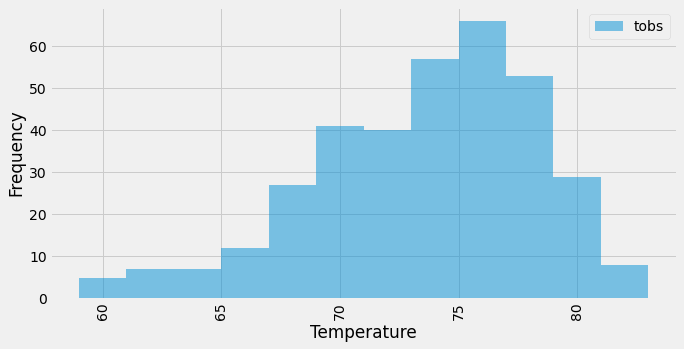

In [302]:
# Choose the station with the highest number of temperature observations.
count_max_number_temperature_station = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs)).all()[-1]
count_max_number_temperature_station
                                                     
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp_df = pd.read_sql(session.query(measurement.date, measurement.tobs).filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23', measurement.station == 'USC00519281').statement,engine)
year_temp_df

temp_index = year_temp_df.set_index('date').sort_index()
temp_index

temp_index.plot.hist(bins=12, alpha=0.5, label="Temperature by Date", rot=90, figsize=(10,5))
plt.xlabel('Temperature')
fig.tight_layout()

## Bonus Challenge Assignment

In [318]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [321]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [342]:
# Plot the results from your previous query as a bar chart. 
calc_temp_df = calc_temps('2011-02-28', '2011-03-05')
min_temp = ('Min Temperature', calc_temp_df[0])

# avg_temp = calc_temp_df[0]
# max_temp = calc_temp_df[0]

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
